In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2


# Any results you write to the current directory are saved as output.

In [2]:
df = pd.read_csv("/kaggle/input/nvidia-self-driving-car-training-set/driving_dataset/data.txt", sep=" ", header=None)
df.head()

,0,1
0,0.jpg,0.0
1,1.jpg,0.0
2,2.jpg,0.0
3,3.jpg,0.0
4,4.jpg,0.0


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def show_img(path):
    img = mpimg.imread(path)
    plt.figure()
    plt.imshow(img)
def otsu(path):
    img = cv2.imread(path, 0)
    ret, o1 = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
    plt.figure()
    plt.imshow(o1)
def print_random_img(n, function, path, lists = [], numbers = []):
    if len(lists) != 0:
        l = lists
    else:
        l = os.listdir(path)
    if len(numbers) != 0:
        for i in numbers:
            try:
                function(os.path.join(path, l[i] +".jpg"))
            except IndexError:
                print("Number in numbers is bigger than length of path list")
    else:
        for i in range(n):
            randomn = random.randint(0, len(l))
            function(os.path.join(path, l[randomn]))

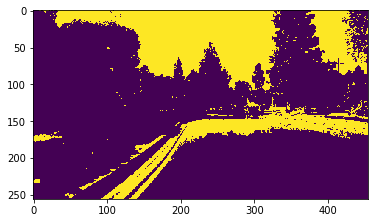

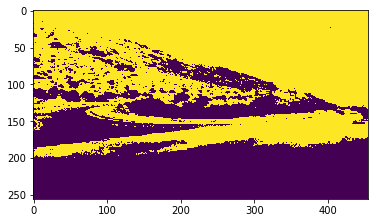

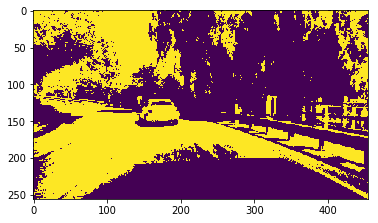

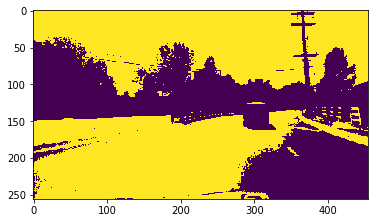

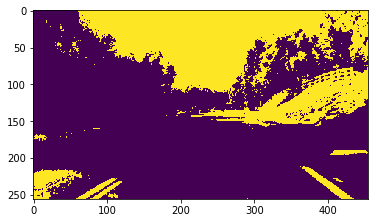

In [4]:
print_random_img(5, otsu,  "/kaggle/input/nvidia-self-driving-car-training-set/driving_dataset/")

In [5]:
x = list(df[0])
df_images = np.asarray(["/kaggle/input/nvidia-self-driving-car-training-set/driving_dataset/"+str(i) for i in x])

In [6]:
def wraparound(x):
    x = x%360
    return x%(np.sign(180-x)*180)

In [7]:
df = pd.DataFrame(list(zip(df_images, df[1].apply(lambda x: 20*math.cos(wraparound(x) * math.pi/180) ), 
                          df[1].apply(lambda x: 20*math.sin(wraparound(x) * math.pi/180) ))), #.apply(lambda x: 20*x)
               columns =['Image', 'Cosine', 'Sine'])

In [8]:
df.head()

,Image,Cosine,Sine
0,/kaggle/input/nvidia-self-driving-car-training...,20.0,0.0
1,/kaggle/input/nvidia-self-driving-car-training...,20.0,0.0
2,/kaggle/input/nvidia-self-driving-car-training...,20.0,0.0
3,/kaggle/input/nvidia-self-driving-car-training...,20.0,0.0
4,/kaggle/input/nvidia-self-driving-car-training...,20.0,0.0


In [9]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df, test_size = 0.2)

In [10]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2
def canny(img):
    plt.figure()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.uint8(img)
    img = cv2.GaussianBlur(img, (5,5), 1.5)
    newimg = cv2.Canny(img, 100, 150).tolist()
    for i in range(len(newimg)):
        for j in range(len(newimg[i])):
            x = newimg[i][j]
            newimg[i][j] = [x,x,x]
    newimg = np.asarray(newimg)
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(img)
    axarr[0,1].imshow(newimg)
    axarr[1,0].imshow(img)
    axarr[1,1].imshow(newimg)
    return newimg

data_generator_with_aug = ImageDataGenerator(
                                   validation_split = 0.2, rotation_range = 10,
                                   zoom_range = 0.1 )

In [11]:
size = 128
class_mode = 'raw'
train_dg_cos = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Cosine", target_size = (size,size),
                                           batch_size = 32, subset = 'training', shuffle = True)
val_dg_cos = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Cosine", target_size = (size,size),
                                           batch_size = 32, subset = 'validation', shuffle = True)
test_dg_cos = data_generator_with_aug.flow_from_dataframe(dataframe= df_test, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Cosine", target_size = (size,size),
                                           batch_size = 32, shuffle = True)

train_dg_sin = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Sine", target_size = (size,size),
                                           batch_size = 32, subset = 'training', shuffle = True)
val_dg_sin = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Sine", target_size = (size,size),
                                           batch_size = 32, subset = 'validation', shuffle = True)
test_dg_sin = data_generator_with_aug.flow_from_dataframe(dataframe= df_test, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Sine", target_size = (size,size),
                                           batch_size = 32, shuffle = True)

Found 29060 validated image filenames.
Found 7264 validated image filenames.
Found 9082 validated image filenames.
Found 29060 validated image filenames.
Found 7264 validated image filenames.
Found 9082 validated image filenames.


In [12]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Flatten, Dropout, Activation, MaxPooling2D, Reshape
from keras.optimizers import SGD
from keras.layers import LSTM, TimeDistributed

def make_model(lstm):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(size, size, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    
    if lstm:
        model.add(TimeDistributed(Dropout(0.5)))
        model.add(Reshape((4, 128)))
        model.add(LSTM(16))
        model.add(Dense(1))
        print(model.summary())
        return model
    else:
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        return model

model_cos_printable = make_model(True)
model_sin_printable = make_model(True)
model_cos = make_model(False)
model_sin = make_model(False)

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

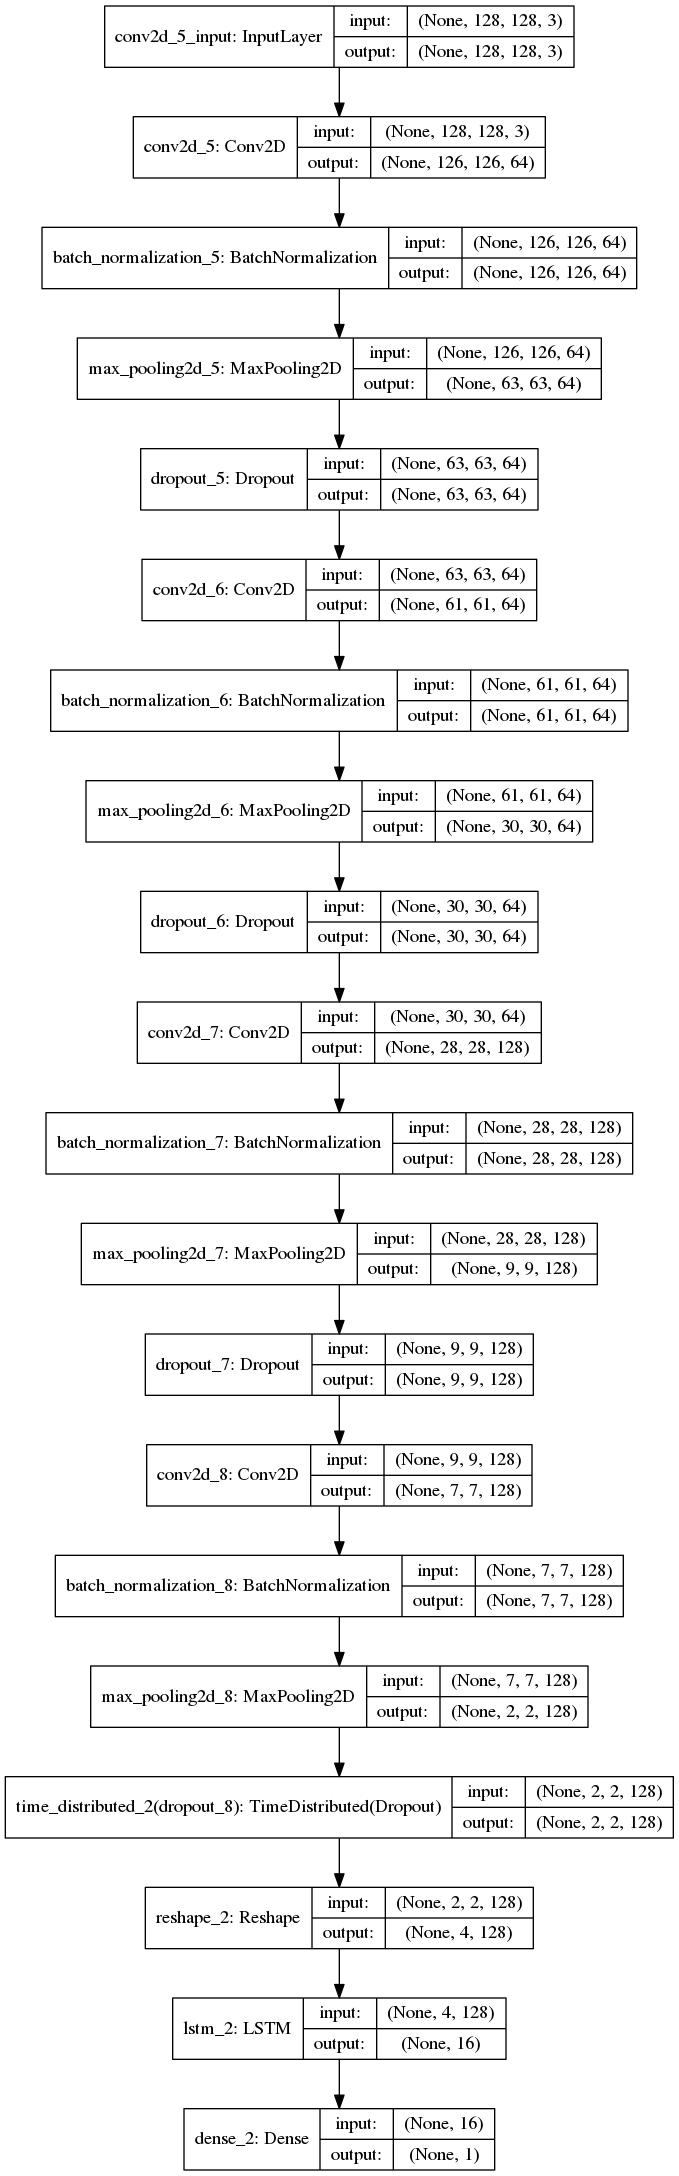

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(model_cos_printable, to_file='model_cos.png', show_shapes=True, show_layer_names=True)
plot_model(model_sin_printable, to_file='model_sin.png', show_shapes=True, show_layer_names=True)

In [14]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.merge import add
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import kullback_leibler_divergence as KLDivergence



def resnet8(img_width, img_height, img_channels, output_dim):
    
    img_input = Input(shape=(img_height, img_width, img_channels))

    x1 = Conv2D(32, (5, 5), strides=[2,2], padding='same')(img_input)
    x1 = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(x1)

    # First residual block
    x2 = keras.layers.normalization.BatchNormalization()(x1)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x2 = keras.layers.normalization.BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x1 = Conv2D(32, (1, 1), strides=[2,2], padding='same')(x1)
    x3 = add([x1, x2])

    # Second residual block
    x4 = keras.layers.normalization.BatchNormalization()(x3)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x4 = keras.layers.normalization.BatchNormalization()(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x3 = Conv2D(64, (1, 1), strides=[2,2], padding='same')(x3)
    x5 = add([x3, x4])

    # Third residual block
    x6 = keras.layers.normalization.BatchNormalization()(x5)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x6 = keras.layers.normalization.BatchNormalization()(x6)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x5 = Conv2D(128, (1, 1), strides=[2,2], padding='same')(x5)
    x7 = add([x5, x6])

    x = Flatten()(x7)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # Steering channel
    steer = Dense(output_dim)(x)

    model = Model(inputs=[img_input], outputs=[steer])
    print(model.summary())

    return model

model_cos.compile(optimizer= 'adam', loss= "mse", metrics=["mse", "mae"])
model_sin.compile(optimizer= 'adam', loss= "mse", metrics=["mse", "mae"])
model_cos_printable.compile(optimizer= 'adam', loss= "mse", metrics=["mse", "mae"])
model_sin_printable.compile(optimizer= 'adam', loss= "mse", metrics=["mse", "mae"])

In [15]:
next(train_dg_sin)[0][0]

array([[[110.355965, 164.06134 , 254.96933 ],
        [110.34421 , 164.06245 , 254.96877 ],
        [110.33245 , 164.06358 , 254.96822 ],
        ...,
        [104.88026 , 183.29555 , 254.69809 ],
        [104.8629  , 183.29163 , 254.69641 ],
        [104.84555 , 183.2877  , 254.69473 ]],

       [[ 90.46451 , 169.35709 , 254.10715 ],
        [ 90.47739 , 169.35373 , 254.10771 ],
        [ 90.49026 , 169.35037 , 254.10828 ],
        ...,
        [105.531364, 175.77121 , 252.53136 ],
        [105.53304 , 175.77681 , 252.53304 ],
        [105.53472 , 175.78241 , 252.53473 ]],

       [[ 97.79636 , 165.10182 , 254.      ],
        [ 97.78964 , 165.10518 , 254.      ],
        [ 97.78293 , 165.10854 , 254.      ],
        ...,
        [107.23918 , 175.49278 , 254.23918 ],
        [107.2375  , 175.49167 , 254.2375  ],
        [107.235825, 175.49055 , 254.23582 ]],

       ...,

       [[ 91.68544 ,  85.54713 , 101.32069 ],
        [ 91.69271 ,  85.55048 , 101.32572 ],
        [ 91.69999 ,  

In [16]:
cos_history = model_cos.fit_generator(
        train_dg_cos,
        steps_per_epoch=29060/32,
        epochs= 25,
        validation_data=val_dg_cos, 
        validation_steps = 7264/32)

Epoch 1/25
909/908 [==============================] - 320s 352ms/step - loss: 112.6325 - mse: 112.7316 - mae: 8.0830 - val_loss: 18.2451 - val_mse: 25.9028 - val_mae: 3.3380
Epoch 2/25
909/908 [==============================] - 245s 270ms/step - loss: 23.4737 - mse: 23.4865 - mae: 2.9645 - val_loss: 14.7475 - val_mse: 15.1529 - val_mae: 2.0342
Epoch 3/25
909/908 [==============================] - 250s 275ms/step - loss: 19.5267 - mse: 19.4718 - mae: 2.7162 - val_loss: 3.4191 - val_mse: 21.1567 - val_mae: 2.0252
Epoch 4/25
909/908 [==============================] - 255s 280ms/step - loss: 16.8134 - mse: 16.8278 - mae: 2.4580 - val_loss: 18.2733 - val_mse: 24.3832 - val_mae: 2.0522
Epoch 5/25
909/908 [==============================] - 260s 286ms/step - loss: 14.4842 - mse: 14.4950 - mae: 2.2736 - val_loss: 16.4445 - val_mse: 13.3828 - val_mae: 1.6074
Epoch 6/25
909/908 [==============================] - 260s 286ms/step - loss: 13.9033 - mse: 13.8031 - mae: 2.2109 - val_loss: 31.5049 - va

In [17]:
sin_history = model_sin.fit_generator(
        train_dg_sin,
        steps_per_epoch=29060/32,
        epochs=25,
        validation_data=val_dg_sin, 
        validation_steps = 7264/32)

Epoch 1/25
909/908 [==============================] - 249s 274ms/step - loss: 23.9166 - mse: 23.7757 - mae: 3.3501 - val_loss: 21.5424 - val_mse: 17.9874 - val_mae: 2.9266
Epoch 2/25
909/908 [==============================] - 246s 270ms/step - loss: 14.4069 - mse: 14.4106 - mae: 2.6185 - val_loss: 18.5094 - val_mse: 15.4300 - val_mae: 2.7912
Epoch 3/25
909/908 [==============================] - 247s 272ms/step - loss: 12.3614 - mse: 12.3595 - mae: 2.4519 - val_loss: 8.8756 - val_mse: 15.9688 - val_mae: 2.5988
Epoch 4/25
909/908 [==============================] - 249s 274ms/step - loss: 10.6036 - mse: 10.5782 - mae: 2.2748 - val_loss: 16.1364 - val_mse: 11.4341 - val_mae: 2.3487
Epoch 5/25
909/908 [==============================] - 247s 272ms/step - loss: 9.8592 - mse: 9.8517 - mae: 2.2085 - val_loss: 6.3442 - val_mse: 11.0669 - val_mae: 2.1305
Epoch 6/25
909/908 [==============================] - 245s 269ms/step - loss: 9.6372 - mse: 9.6412 - mae: 2.1748 - val_loss: 12.3441 - val_mse: 

In [18]:
train_dg_cos_p = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Cosine", target_size = (size,size),
                                           batch_size = 32, subset = 'training', shuffle = False)
val_dg_cos_p = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Cosine", target_size = (size,size),
                                           batch_size = 32, subset = 'validation', shuffle = False)
test_dg_cos_p = data_generator_with_aug.flow_from_dataframe(dataframe= df_test, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Cosine", target_size = (size,size),
                                           batch_size = 32, shuffle = False)

train_dg_sin_p = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Sine", target_size = (size,size),
                                           batch_size = 32, subset = 'training', shuffle = False)
val_dg_sin_p = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Sine", target_size = (size,size),
                                           batch_size = 32, subset = 'validation', shuffle = False)
test_dg_sin_p = data_generator_with_aug.flow_from_dataframe(dataframe= df_test, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Sine", target_size = (size,size),
                                           batch_size = 32, shuffle = False)

Found 29060 validated image filenames.
Found 7264 validated image filenames.
Found 9082 validated image filenames.
Found 29060 validated image filenames.
Found 7264 validated image filenames.
Found 9082 validated image filenames.


In [19]:
cos_history_p = model_cos_printable.fit_generator(
        train_dg_cos_p,
        steps_per_epoch=29060/32,
        epochs= 25,
        validation_data=val_dg_cos_p, 
        validation_steps = 7264/32)

sin_history_p = model_sin_printable.fit_generator(
        train_dg_cos_p,
        steps_per_epoch=29060/32,
        epochs= 25,
        validation_data=val_dg_cos_p, 
        validation_steps = 7264/32)

Epoch 1/25
909/908 [==============================] - 255s 281ms/step - loss: 94.8856 - mse: 94.9560 - mae: 8.7555 - val_loss: 17.8526 - val_mse: 35.4961 - val_mae: 4.6780
Epoch 2/25
909/908 [==============================] - 249s 274ms/step - loss: 26.5022 - mse: 26.5170 - mae: 3.1184 - val_loss: 1.7511 - val_mse: 23.3079 - val_mae: 2.3777
Epoch 3/25
909/908 [==============================] - 248s 273ms/step - loss: 19.3994 - mse: 19.4064 - mae: 2.0405 - val_loss: 2.7170 - val_mse: 16.5018 - val_mae: 1.8660
Epoch 4/25
909/908 [==============================] - 247s 272ms/step - loss: 14.7377 - mse: 14.7394 - mae: 1.7042 - val_loss: 9.9917 - val_mse: 13.3376 - val_mae: 1.7088
Epoch 5/25
909/908 [==============================] - 247s 272ms/step - loss: 12.2572 - mse: 12.2601 - mae: 1.5356 - val_loss: 0.9893 - val_mse: 11.7913 - val_mae: 1.3148
Epoch 6/25
909/908 [==============================] - 247s 272ms/step - loss: 11.3392 - mse: 11.3357 - mae: 1.4470 - val_loss: 0.5613 - val_mse:

{'val_loss': [18.245084762573242, 14.747482299804688, 3.419076681137085, 18.273286819458008, 16.444501876831055, 31.504941940307617, 112.20838928222656, 30.737890243530273, 16.484344482421875, 4.183274269104004, 4.781573295593262, 69.3384780883789, 27.335147857666016, 26.862747192382812, 4.187531471252441, 31.2719669342041, 4.0476274490356445, 41.830963134765625, 16.8978328704834, 46.621036529541016, 0.9242241382598877, 0.9184955358505249, 3.5786631107330322, 6.108337879180908, 3.1376819610595703], 'val_mse': [25.90275764465332, 15.152935981750488, 21.15665626525879, 24.383197784423828, 13.382750511169434, 15.332938194274902, 16.49646759033203, 20.893829345703125, 14.410103797912598, 20.012004852294922, 12.408885955810547, 32.235382080078125, 10.259450912475586, 19.344099044799805, 21.286745071411133, 12.583942413330078, 23.424625396728516, 19.002511978149414, 26.141361236572266, 14.76480484008789, 12.61917495727539, 10.334759712219238, 11.74062442779541, 13.057992935180664, 14.9609680

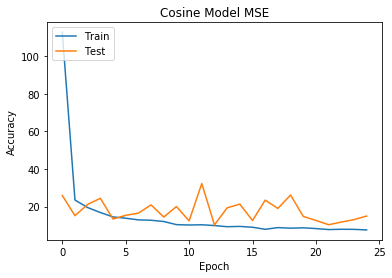

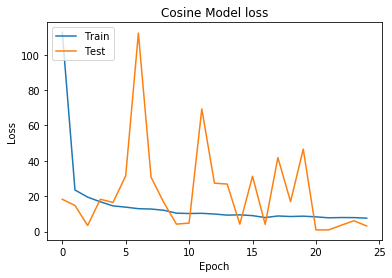

{'val_loss': [21.542360305786133, 18.509368896484375, 8.87563419342041, 16.13638687133789, 6.344167709350586, 12.344135284423828, 6.908105373382568, 6.774315357208252, 3.8066585063934326, 13.289653778076172, 7.461493968963623, 3.8807530403137207, 4.8963823318481445, 7.696039199829102, 8.053213119506836, 3.5756161212921143, 5.574032783508301, 3.8806095123291016, 1.5441521406173706, 2.0027031898498535, 2.6673338413238525, 11.435542106628418, 4.974430561065674, 3.4418063163757324, 7.232815742492676], 'val_mse': [17.987411499023438, 15.430015563964844, 15.9688138961792, 11.434110641479492, 11.066859245300293, 13.241839408874512, 11.199748992919922, 5.771397590637207, 5.518369197845459, 7.628843307495117, 6.489408493041992, 8.034012794494629, 8.078839302062988, 5.106154441833496, 4.589324951171875, 5.330710411071777, 4.094408988952637, 5.3783674240112305, 4.611245632171631, 4.278078556060791, 4.018109321594238, 10.704096794128418, 4.16035795211792, 4.497041702270508, 4.950162887573242], 'va

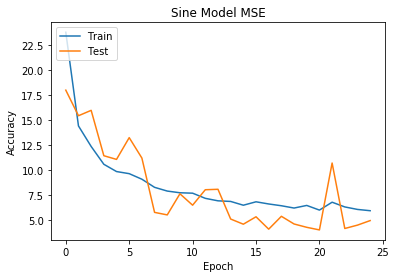

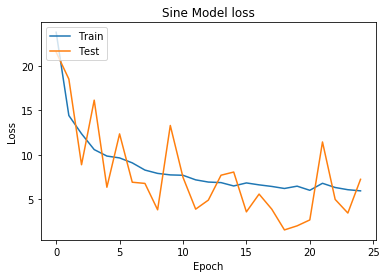

<Figure size 432x288 with 0 Axes>

In [20]:
history = cos_history
print(history.history)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Cosine Model MSE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("Cosine_MSE.jpg")
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cosine Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("Cosine_Loss.jpg")

history = sin_history
print(history.history)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Sine Model MSE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("Sine_MSE.jpg")
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Sine Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("Sine_Loss.jpg")

Velocity is: 20.0 0.0
Velocity is: 20.0 0.0


KeyError: 2

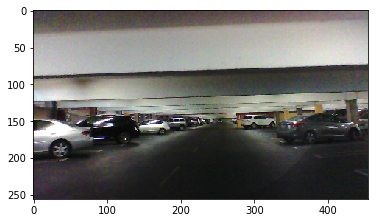

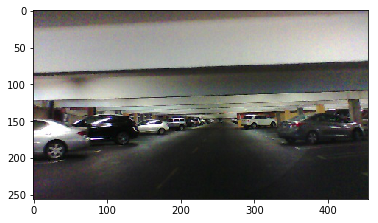

In [21]:
for i in range(10):
    show_img(df["Image"][i])
    print("Velocity is:", df["Cosine"][i], df["Sine"][i])

In [22]:
from PIL import Image
def predict(df_test,number,model_c, model_s, divide = False, which = 'Both'):
    df = np.array_split(df_test, int(len(df_test)/ number))[0]
    array_pred = []
    array_real = []
    for i in range(len(df)):
        im = Image.open(df['Image'].iloc()[i])
        im = np.asarray(im.resize((size, size)))
        cos = model_c.predict(np.asarray([im])).tolist()[0][0]
        sin = model_s.predict(np.asarray([im])).tolist()[0][0]
        angle = math.degrees(math.atan2(sin, cos))
        if which == 'Both':
            array_pred.append(angle)
        elif which == 'Sine':
            array_pred.append(sin)
        elif which == 'Cosine':
            array_pred.append(cos)
        else:
            print("BAAADD")
        if divide:
            array_real.append(float(df['Label'].iloc()[i])/20)
        else:
            cos = df['Cosine'].iloc()[i]
            sin = df['Sine'].iloc()[i]
            angle = math.degrees(math.atan2(sin, cos))
            if which == 'Both':
                array_real.append(angle)
            elif which == 'Sine':
                array_real.append(sin)
            elif which == 'Cosine':
                array_real.append(cos)
            else:
                print("BAAAAAD")
        
    return [(round(array_pred[i], 2), array_real[i]) for i in range(len(array_pred))]
        
        

In [23]:
from keras.models import load_model
model_cos = load_model("/kaggle/input/models/model_cos_1.h5")
model_sin = load_model("/kaggle/input/models/model_sin_1.h5")

(-100, 200)

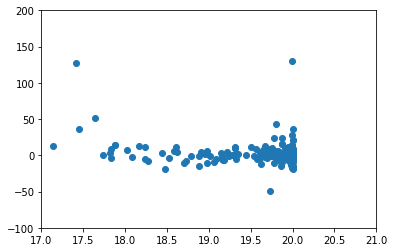

In [24]:
u = predict(df_test, 250,model_cos, model_sin, divide = False, which = 'Cosine')
plt.scatter([i[1] for i in u ], [ (i[1] - i[0])*100/i[1] for i in u ])
plt.xlim(17,21)
plt.ylim(-100, 200)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


(-200, 200)

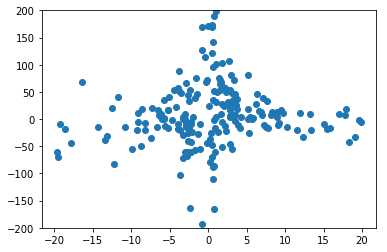

In [25]:
u = predict(df_test, 250,model_cos, model_sin, divide = False, which = 'Sine')
plt.scatter([i[1] for i in u ], [ (i[1] - i[0])*100/i[1] for i in u ])
plt.ylim(-200,200)